First off, just read the data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
df = pd.read_csv("results.csv")

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
df

,App,Key,Logical Lines of Code,Halstead Volume,Halstead Difficulty,Halstead Effort,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99,Number of Words
0,insurance_claims,fbp_app_min,210,543.658677,6.210526,3376.406518,43.30,1.93478,6,0.424242,4,846
1,insurance_claims,fbp_app_data,239,610.424232,6.190476,3778.816672,40.80,2.12500,8,0.657143,5,974
2,insurance_claims,fbp_app_ml,263,543.658677,6.848214,3723.091116,41.85,2.29412,6,0.918919,7,1124
3,insurance_claims,soa_app_min,250,383.285425,6.000000,2299.712549,46.22,1.36364,2,1.166670,4,1094
4,insurance_claims,soa_app_data,285,463.722322,7.000000,3246.056251,44.19,1.41667,2,1.176470,4,1247
5,insurance_claims,soa_app_ml,356,675.754180,7.101449,4798.834030,38.49,1.38462,2,1.487180,9,1508
6,mblogger,fbp_app_min,172,155.114511,2.000000,310.229021,44.10,1.81081,5,0.307692,2,529
7,mblogger,fbp_app_data,259,331.413717,3.000000,994.241152,32.92,1.96364,5,0.500000,4,796
8,mblogger,fbp_app_ml,310,433.601979,3.061224,1327.352995,29.14,1.95312,5,0.500000,4,960
9,mblogger,soa_app_min,240,213.673439,3.000000,641.020318,46.93,1.75000,3,1.142860,3,1002


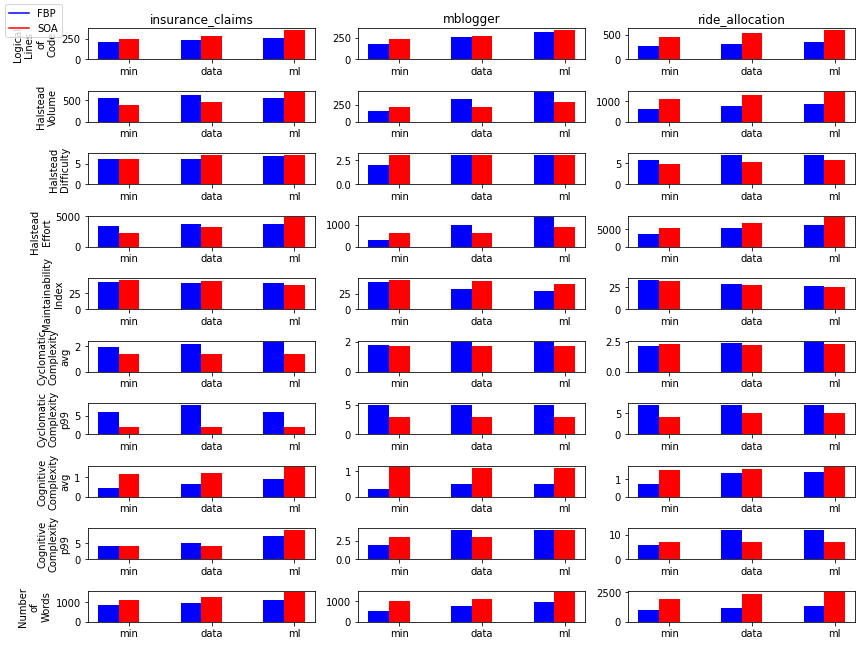

In [5]:
apps = df["App"].unique().tolist()
metrics = df.columns[2:].tolist()

fig, axes = plt.subplots(nrows=len(metrics), ncols=len(apps), figsize=(12, 9))

for ax, app in zip(axes[0], apps):
    ax.set_title(app);

for ax, metric in zip(axes[:,0], metrics):
    ax.set_ylabel(metric.replace(' ', "\n"), size=10);

for ir, metric in enumerate(metrics):
    for ic, app in enumerate(apps):
        values = df[df["App"] == app][["Key", metric]]
        values_fbp = values.loc[values['Key'].isin(['fbp_app_min','fbp_app_data','fbp_app_ml'])]
        values_soa = values.loc[values['Key'].isin(['soa_app_min','soa_app_data','soa_app_ml'])]
        labels = [k[k.rfind('_')+1:] for k in values_fbp["Key"]]
        X = np.arange(len(values_fbp))
        axes[ir][ic].bar(
            X, values_fbp[metric], width=0.25,
            tick_label=labels, align='center', color='b'
        );
        axes[ir][ic].bar(
            X+0.25, values_soa[metric], width=0.25,
            tick_label=labels, align='center', color='r'
        );
        
        

fig.tight_layout();


legend_elements = [Line2D([0], [0], color='b', label='FBP'),
                   Line2D([0], [0], color='r', label='SOA')]

fig.legend(handles=legend_elements, loc='upper left')

plt.show();

Some metrics scale with the size of the codebase, while others don't. For the former we calculate change in percentages, for the latter in absolute values.

In [6]:
absolute_diff_metrics = [
    "Halstead Difficulty", "Maintainability Index",
    "Cyclomatic Complexity avg", "Cyclomatic Complexity p99",
    "Cognitive Complexity avg", "Cognitive Complexity p99"
]
percentage_diff_metrics = [
    "Logical Lines of Code", "Halstead Volume",
    "Halstead Effort", "Number of Words"
]

Here we calculate the differences and re-organize the dataframe a bit.

In [7]:
all_dfs = []

for i in range(0, df.shape[0], 3):
    df_change = pd.concat([
        df.iloc[i:i+3, 2:][percentage_diff_metrics].pct_change(),
        df.iloc[i:i+3, 2:][absolute_diff_metrics].diff(),
    ], axis=1)
    df_change.insert(0, "App", df["App"])
    df_change = df_change.iloc[1: , :]
    df_change.insert(1, "Keys", ["min/data", "data/ml"])
    all_dfs.append(df_change)

fbp_dfs = [all_dfs[0], all_dfs[2], all_dfs[4]]
soa_dfs = [all_dfs[1], all_dfs[3], all_dfs[5]]
    
for fbp_df in fbp_dfs:
    fbp_df.insert(1, "Paradigm", ["fbp", "fbp"])
for soa_df in soa_dfs:
    soa_df.insert(1, "Paradigm", ["soa", "soa"])

all_changes_df = pd.concat(fbp_dfs + soa_dfs, axis=0)
all_changes_df

,App,Paradigm,Keys,Logical Lines of Code,Halstead Volume,Halstead Effort,Number of Words,Halstead Difficulty,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99
1,insurance_claims,fbp,min/data,0.138095,0.122808,0.119183,0.151300,-0.020050,-2.50,0.19022,2.0,0.232901,1.0
2,insurance_claims,fbp,data/ml,0.100418,-0.109376,-0.014747,0.154004,0.657738,1.05,0.16912,-2.0,0.261776,2.0
7,mblogger,fbp,min/data,0.505814,1.136575,2.204862,0.504726,1.000000,-11.18,0.15283,0.0,0.192308,2.0
8,mblogger,fbp,data/ml,0.196911,0.308340,0.335041,0.206030,0.061224,-3.78,-0.01052,0.0,0.000000,0.0
13,ride_allocation,fbp,min/data,0.171533,0.223463,0.451884,0.207113,1.094453,-4.47,0.27290,0.0,0.653398,6.0
14,ride_allocation,fbp,data/ml,0.121495,0.148057,0.157376,0.126516,0.056465,-2.71,0.02339,0.0,0.009760,0.0
4,insurance_claims,soa,min/data,0.140000,0.209862,0.411505,0.139854,1.000000,-2.03,0.05303,0.0,0.009800,0.0
5,insurance_claims,soa,data/ml,0.249123,0.457239,0.478358,0.209302,0.101449,-5.70,-0.03205,0.0,0.310710,5.0
10,mblogger,soa,min/data,0.104167,0.000000,0.000000,0.141717,0.000000,-1.82,0.00000,0.0,-0.009530,0.0
11,mblogger,soa,data/ml,0.279245,0.362758,0.362758,0.270979,0.000000,-4.93,-0.01667,0.0,-0.025220,1.0


In the resulting dataframe columns contain measured changes for different apps. "Keys" column signifies which pair is considered. E.g. "min/data" means that changes are measured for transition between "min" and "data" stages.

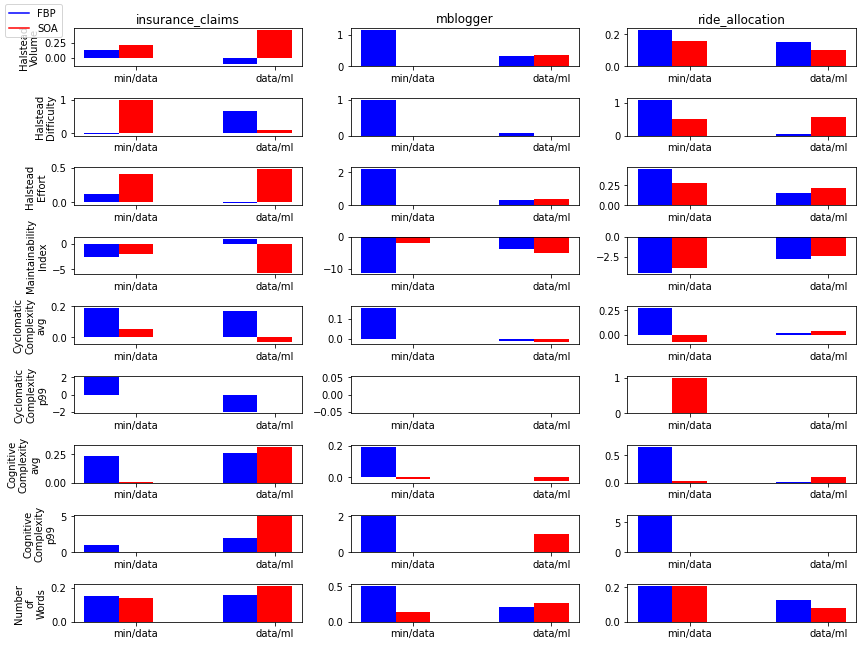

In [8]:
apps = all_changes_df["App"].unique().tolist()
metrics = df.columns[3:].tolist()

fig, axes = plt.subplots(nrows=len(metrics), ncols=len(apps), figsize=(12, 9))

for ax, app in zip(axes[0], apps):
    ax.set_title(app);

for ax, metric in zip(axes[:,0], metrics):
    ax.set_ylabel(metric.replace(' ', "\n"), size=10);

for ir, metric in enumerate(metrics):
    for ic, app in enumerate(apps):
        values = all_changes_df[all_changes_df["App"] == app][["Paradigm", "Keys", metric]]
        values_fbp = values.loc[values['Paradigm'].isin(['fbp'])]
        values_soa = values.loc[values['Paradigm'].isin(['soa'])]
        labels = [k[k.rfind('_')+1:] for k in values_fbp["Paradigm"]]
        X = np.arange(len(values_fbp))
        colors = ['b' if k == 'fbp' else 'r' for k in values["Paradigm"]]
        labels = values_fbp["Keys"]
        axes[ir][ic].bar(
            X, values_fbp[metric], width=0.25,
            tick_label=labels, align='center', color='b'
        );
        axes[ir][ic].bar(
            X+0.25, values_soa[metric], width=0.25,
            tick_label=labels, align='center', color='r'
        );

fig.tight_layout();


legend_elements = [Line2D([0], [0], color='b', label='FBP'),
                   Line2D([0], [0], color='r', label='SOA')]

fig.legend(handles=legend_elements, loc='upper left')

plt.show();

Let's look at individual stages, or rather pairs of stages.

In [9]:
min_data_changes_df = all_changes_df[all_changes_df["Keys"] == 'min/data']
data_ml_changes_df = all_changes_df[all_changes_df["Keys"] == 'data/ml']

In [10]:
min_data_changes_df

,App,Paradigm,Keys,Logical Lines of Code,Halstead Volume,Halstead Effort,Number of Words,Halstead Difficulty,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99
1,insurance_claims,fbp,min/data,0.138095,0.122808,0.119183,0.151300,-0.020050,-2.50,0.19022,2.0,0.232901,1.0
7,mblogger,fbp,min/data,0.505814,1.136575,2.204862,0.504726,1.000000,-11.18,0.15283,0.0,0.192308,2.0
13,ride_allocation,fbp,min/data,0.171533,0.223463,0.451884,0.207113,1.094453,-4.47,0.27290,0.0,0.653398,6.0
4,insurance_claims,soa,min/data,0.140000,0.209862,0.411505,0.139854,1.000000,-2.03,0.05303,0.0,0.009800,0.0
10,mblogger,soa,min/data,0.104167,0.000000,0.000000,0.141717,0.000000,-1.82,0.00000,0.0,-0.009530,0.0
16,ride_allocation,soa,min/data,0.215247,0.158409,0.277145,0.204927,0.492901,-3.87,-0.07440,1.0,0.026260,0.0


In [11]:
data_ml_changes_df

,App,Paradigm,Keys,Logical Lines of Code,Halstead Volume,Halstead Effort,Number of Words,Halstead Difficulty,Maintainability Index,Cyclomatic Complexity avg,Cyclomatic Complexity p99,Cognitive Complexity avg,Cognitive Complexity p99
2,insurance_claims,fbp,data/ml,0.100418,-0.109376,-0.014747,0.154004,0.657738,1.05,0.16912,-2.0,0.261776,2.0
8,mblogger,fbp,data/ml,0.196911,0.308340,0.335041,0.206030,0.061224,-3.78,-0.01052,0.0,0.000000,0.0
14,ride_allocation,fbp,data/ml,0.121495,0.148057,0.157376,0.126516,0.056465,-2.71,0.02339,0.0,0.009760,0.0
5,insurance_claims,soa,data/ml,0.249123,0.457239,0.478358,0.209302,0.101449,-5.70,-0.03205,0.0,0.310710,5.0
11,mblogger,soa,data/ml,0.279245,0.362758,0.362758,0.270979,0.000000,-4.93,-0.01667,0.0,-0.025220,1.0
17,ride_allocation,soa,data/ml,0.099631,0.098153,0.212133,0.081340,0.550276,-2.45,0.03463,0.0,0.113100,0.0
